# Introduction

This practical is following the epigenomics course Hands-On found from this link: https://github.com/bborsari/epigenomics_uvic/wiki. In part 2 is taught how to process ChIP-seq data and analyse it in order to map the genomic location of a protein of interest. In part 3, we learn how to use ENCODE portal to realize downstream analysis of ChIP-seq data (EN-TEx project) and we compare ChIP-seq data from two different tissues: signmoid colon and stomach. In part 4, we will start analysing ATAC-seq data, generating data on chromatin accessibility, while ChIP-seq was providing data on protein-DNA interactions. Finally, in part 5, we will identify and analyze distal regulatory regions in stomach and sigmoid colon tissues by selecting regions flanked by the markers H3K27ac and H3K4me1, determining their proximity to protein-coding genes on chromosome 1, and computing statistics on the distances between these regulatory elements and their nearest genes using a Python script and R.

# Setup

From nowon we will use WSL, inside the epigenomics_uvic folder where the handson has been previously realized. The folowing command runs a Docker container using the image "dgarrimar/epigenomics_course", mounts the current directory into the container, sets the working directory to the current directory, and provides an interactive terminal for interaction.

In [ ]:
cd mnt/c/Users/elodi/Documents/Documents/BIOINFORMATICS_UVIC/5.Epigenetics/epigenomics_uvic

sudo docker run -v $PWD:$PWD -w $PWD --rm -it dgarrimar/epigenomics_course

# Part 4: EN‐TEx ATAC‐seq data

### Task 1

Move to folder ATAC-seq, and create folders to store bigBed data files and peaks analyses files. Make sure the files are organized in a consistent way as done for ChIP-seq.

In [ ]:
cd ATAC-seq
mkdir analyses, annotation, data
mkdir -p data/bigBed.files data/bigWig.files
mkdir data/bed.files
mkdir analyses/peaks.analysis

### Task 2

Retrieve from a newly generated metadata file ATAC-seq peaks (bigBed narrow, pseudoreplicated peaks, assembly GRCh38) for stomach and sigmoid_colon for the same donor used in the previous sections. Hint: have a look at what we did in 3.2. Make sure your md5sum values coincide with the ones provided by ENCODE.

First we get the metadata from ENCODE portal. We retrieve information on DNA accessibility, ATAC-seq, stomach and sigmoid colon. We go to bin folder and use the file download.metadata.sh to download the url following, then transform this url information into a file called metadata.tsv, which will be located where we do the command, so in ATAC-seq folder. 

In [ ]:
../bin/download.metadata.sh "https://www.encodeproject.org/metadata/?replicates.library.biosample.donor.uuid=d370683e-81e7-473f-8475-7716d027849b&status=released&status=submitted&status=in+progress&assay_slims=DNA+accessibility&assay_title=ATAC-seq&biosample_ontology.term_name=sigmoid+colon&biosample_ontology.term_name=stomach&type=Experiment"

We look at columns information with the following command:

In [ ]:
head -1 metadata.tsv | awk 'BEGIN{FS=OFS="\t"}{for (i=1;i<=NF;i++){print $i, i}}'

We will need the first column (ID), 11 (Biosample_term_name) but not anymore the column 23 (Experiment_target) as we are doing ATAC-seq now (no target anymore). We also remove H3K4me3 (only for ChIP-seq). From the downloaded metadata tsv file, we filter bigBed peaks, pseudoreplicated peaks and GRCh38, extract the columns 1 and 11, sort by tissue and ID and save this in a text file. Finally we extract the files of interest. 

In [ ]:
grep -F "bigBed_narrowPeak" metadata.tsv |\
grep -F "bigBed_narrowPeak" |\
grep -F "pseudoreplicated_peaks" |\
grep -F "GRCh38" |\
awk 'BEGIN{FS=OFS="\t"}{print $1, $11}' |\
sort -k2,2 -k1,1r |\
sort -k2,2 -u > analyses/bigBed.peaks.ids.txt

cut -f1 analyses/bigBed.peaks.ids.txt |\
while read filename; do
  wget -P data/bigBed.files "https://www.encodeproject.org/files/$filename/@@download/$filename.bigBed"
done

We checked that what you saw is indeed in the portal. 

In [ ]:
ls data/bigBed.files/

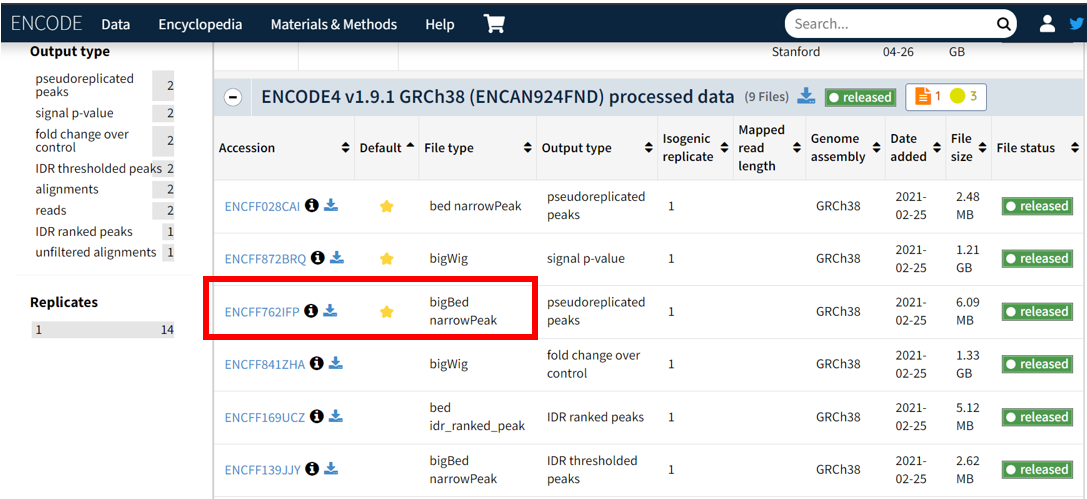

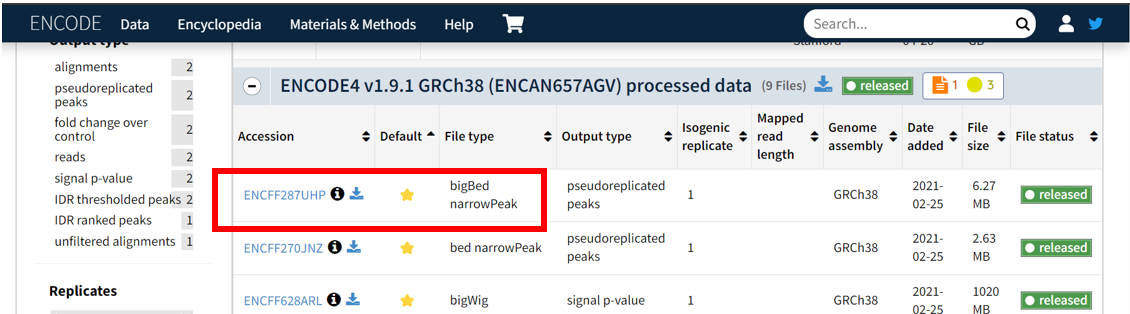

We obtain the following files below. In the portal, in stomach file details, we indeed find ENCFF762IFP and in sigmoid colon file details we also find ENCFF287UHP.

- ENCFF287UHP.bigBed
- ENCFF287UHP.bigBed.1
- ENCFF762IFP.bigBed
- ENCFF762IFP.bigBed.1
- md5sum.txt

We then check integrity of the files with the following command line checking MD5 hash using md5sum (extraction of the MD5 hash of the metadata, then creation of MD5 hashes for the files and similarity check). No message appear, indicating the integrity of the files. 



In [ ]:
for file_type in bigBed; do
  ../bin/selectRows.sh <(cut -f1 analyses/"$file_type".*.ids.txt) metadata.tsv | cut -f1,46 > data/"$file_type".files/md5sum.txt
  cat data/"$file_type".files/md5sum.txt | while read filename original_md5sum; do
    md5sum data/"$file_type".files/"$filename"."$file_type" | awk -v filename="$filename" -v original_md5sum="$original_md5sum" 'BEGIN{FS=" "; OFS="\t"}{print filename, original_md5sum, $1}'
  done > tmp
  mv tmp data/"$file_type".files/md5sum.txt
  awk '$2!=$3' data/"$file_type".files/md5sum.txt
done

Finally, recycle annotation files used previously in ChIP-seq analysis

In [ ]:
cp ../ChIP-seq/annotation/*v24*.bed ./annotation

### Task 3

For each tissue, run an intersection analysis using BEDTools: report 
- the number of peaks that intersect promoter regions, 
- the number of peaks that fall outside gene coordinates (whole gene body, not just the promoter regions). Hint: have a look at what we did here and here.


First, we need to convert bigBed files of H3K4me3 peaks to BED files with the bigBedToBed command

In [ ]:
cut -f1 analyses/bigBed.peaks.ids.txt |\
while read filename; do
  bigBedToBed data/bigBed.files/"$filename".bigBed data/bed.files/"$filename".bed
done

For peaks which intersect promoter regions, we use the command bedtools intersect with our bed files as first argument, the protein coding non redundant TSS bed file as second argument (promoter region), we use parameter -u to look for unique peaks overlapping at least one TSS. 

In [ ]:
cut -f-2 analyses/bigBed.peaks.ids.txt |\
while read filename tissue; do 
  bedtools intersect -a data/bed.files/"$filename".bed -b annotation/gencode.v24.protein.coding.non.redundant.TSS.bed -u > analyses/peaks.analysis/peaks.in.promoters."$tissue".txt
done

For the second part, we also use bedtools intersect but this time the second argument is the protein coding gene body, not just the promoter region, and we look for peaks outside the TSS so we use the option -v instead of -u (NO overlap in gene body).

In [ ]:
cut -f-2 analyses/bigBed.peaks.ids.txt |\
while read filename tissue; do 
  bedtools intersect -a data/bed.files/"$filename".bed -b annotation/gencode.v24.protein.coding.gene.body.bed -v > analyses/peaks.analysis/peaks.outside.gene.body."$tissue".txt
done

We obtain the following results:

In [ ]:
wc -l analyses/peaks.analysis/*
   47871 analyses/peaks.analysis/peaks.in.promoters.sigmoid_colon.txt
   44749 analyses/peaks.analysis/peaks.in.promoters.stomach.txt
   37035 analyses/peaks.analysis/peaks.outside.gene.body.sigmoid_colon.txt
   34537 analyses/peaks.analysis/peaks.outside.gene.body.stomach.txt

Now we create bed files necessary for part 2:

In [ ]:
cut -f-2 analyses/bigBed.peaks.ids.txt |\
while read filename tissue; do 
  bedtools intersect -a data/bed.files/"$filename".bed -b annotation/gencode.v24.protein.coding.gene.body.bed -v > analyses/peaks.analysis/peaks.outside.gene.body."$tissue".bed
done

# Part 5: Distal regulatory activity

From section 4., you should have obtained a set of ATAC-seq peaks in stomach and sigmoid_colon that lie outside gene coordinates. We will use these peaks as a starting point to build a catalogue of distal regulatory regions.

### Task 1

Create a folder regulatory_elements inside epigenomics_uvic. This will be the folder where you store all your subsequent results.

In [ ]:
cd ..
mkdir regulatory_elements 
cd regulatory_elements

### Task 2

Distal regulatory regions are usually found to be flanked by both H3K27ac and H3K4me1. From your starting catalogue of open regions in each tissue, select those that overlap peaks of H3K27ac AND H3K4me1 in the corresponding tissue. You will get a list of candidate distal regulatory elements for each tissue. How many are they?

We need to use the metadata from ChIP-seq analysis. Create folders and retrieve peaks for each marker.

In [ ]:
mkdir analyses
mkdir data
mkdir data/bigBed.files 

H3K27ac:

In [ ]:
grep -F H3K27ac ../ChIP-seq/metadata.tsv |\
grep -F "bigBed_narrowPeak" |\
grep -F "pseudoreplicated_peaks" |\
grep -F "GRCh38" |\
awk 'BEGIN{FS=OFS="\t"}{print $1, $11, $23}' |\
sort -k2,2 -k1,1r |\
sort -k2,2 -u > analyses/bigBed.peaks.ids.H3K27ac.txt

cut -f1 analyses/bigBed.peaks.ids.H3K27ac.txt |\
while read filename; do
  wget -P data/bigBed.files "https://www.encodeproject.org/files/$filename/@@download/$filename.bigBed"
donea

H3K4me1:

In [ ]:
grep -F H3K4me1 ../ChIP-seq/metadata.tsv |\
grep -F "bigBed_narrowPeak" |\
grep -F "pseudoreplicated_peaks" |\
grep -F "GRCh38" |\
awk 'BEGIN{FS=OFS="\t"}{print $1, $11, $23}' |\
sort -k2,2 -k1,1r |\
sort -k2,2 -u > analyses/bigBed.peaks.ids.H3K4me1.txt

cut -f1 analyses/bigBed.peaks.ids.H3K4me1.txt |\
while read filename; do
  wget -P data/bigBed.files "https://www.encodeproject.org/files/$filename/@@download/$filename.bigBed"
done

Check integrity(no output so it's correct):

In [ ]:
for file_type in bigBed; do

  ../bin/selectRows.sh <(cut -f1 analyses/*"$file_type".peaks.ids.txt) ../ChIP-seq/metadata.tsv | cut -f1,46 > data/"$file_type".files/md5sum.txt

  cat data/"$file_type".files/md5sum.txt |\
  while read filename original_md5sum; do 
    md5sum data/"$file_type".files/"$filename"."$file_type" |\
    awk -v filename="$filename" -v original_md5sum="$original_md5sum" 'BEGIN{FS=" "; OFS="\t"}{print filename, original_md5sum, $1}' 
  done > tmp 
  mv tmp data/"$file_type".files/md5sum.txt

  awk '$2!=$3' data/"$file_type".files/md5sum.txt

done

We now convert bigbed format to bed format:

In [ ]:
mkdir data/bed.files

cut -f1 analyses/bigBed.peaks.ids.H3K4me1.txt |\
while read filename; do
  bigBedToBed data/bigBed.files/"$filename".bigBed data/bed.files/"$filename".bed
done

cut -f1 analyses/bigBed.peaks.ids.H3K27ac.txt |\
while read filename; do
  bigBedToBed data/bigBed.files/"$filename".bigBed data/bed.files/"$filename".bed
done

Now, we will use the ATAC-seq files to the open regions in each tissue and find regions which overlap at least once the peaks of H3K27ac in the corresponding tissue, and which overlap at least once the peaks of H3K4me1 in the corresponding tissue. We will use bedtools intersect with the parameter -u which is keeping only the overlapping regions between the two arguments -a and -b. We need to use the following files:

In [ ]:
analyses/bigBed.peaks.ids.H3K4me1.txt # contains info that ENCFF724ZOF is sigmoid_colon and  ENCFF844XRN is stomach
analyses/bigBed.peaks.ids.H3K27ac.txt # contains info that ENCFF872UHN is sigmoid_colon and ENCFF977LBD is stomach
data/bed.files/ENCFF724ZOF.bed (H3K4me1 sigmoid_colon)
data/bed.files/ENCFF844XRN.bed (H3K4me1 stomach)
data/bed.files/ENCFF872UHN.bed (H3K27ac sigmoid_colon)
data/bed.files/ENCFF977LBD.bed (H3K27ac stomach)
../ATAC-seq/analyses/peaks.analysis/peaks.outside.gene.body.sigmoid_colon.bed
../ATAC-seq/analyses/peaks.analysis/peaks.outside.gene.body.stomach.bed

- Regions overlapping with H3K4me1 peaks for each tissue:

In [ ]:
cut -f-2 analyses/bigBed.peaks.ids.H3K4me1.txt |
while read filename tissue; do 
    bedtools intersect -a data/bed.files/"$filename".bed \
                       -b ../ATAC-seq/analyses/peaks.analysis/peaks.outside.gene.body."$tissue".bed \
                       -u > analyses/intersect_H3K4me1_outside.gene."$tissue".bed
done

- Regions overlapping with H3K27ac peaks for each tissue:

In [ ]:
cut -f-2 analyses/bigBed.peaks.ids.H3K27ac.txt |
while read filename tissue; do 
    bedtools intersect -a data/bed.files/"$filename".bed \
                       -b ../ATAC-seq/analyses/peaks.analysis/peaks.outside.gene.body."$tissue".bed \
                       -u > analyses/intersect_H3K27ac_outside.gene."$tissue".bed
done

- Regions overlapping with H3K4me1 and H3K27ac peaks for each tissue (candidate distal regulatory elements):

In [ ]:
for tissue in sigmoid_colon stomach; do
    bedtools intersect -a analyses/intersect_H3K4me1_outside.gene."$tissue".bed \
                       -b analyses/intersect_H3K27ac_outside.gene."$tissue".bed \
                       -u > analyses/candidate_distal_regulatory_elements_"$tissue".bed
done

The number of candidates for distal regulatory elements is 8457 for sigmoid colon and 4988 for stomach (see below).

In [ ]:
wc -l analyses/*distal*.bed
  8457 analyses/candidate_distal_regulatory_elements_sigmoid_colon.bed
  4988 analyses/candidate_distal_regulatory_elements_stomach.bed
 13445 total

### Task 3

Focus on regulatory elements that are located on chromosome 1 (hint: to parse a file based on the value of a specific column, have a look at what we did before), and generate a file regulatory.elements.starts.tsv that contains the name of the regulatory region (i.e. the name of the original ATAC-seq peak) and the start (5') coordinate of the region.

Let's look at information given in the regulatory elements files:

In [ ]:
head -1 analyses/candidate_distal_regulatory_elements_stomach.bed | awk 'BEGIN{FS=OFS="\t"}{for (i=1;i<=NF;i++){print $i, i}}'

chr1    1
1068237 2
1070265 3
Peak_7541       4
282     5
.       6
4.37587 7
13.14936        8
9.80414 9
1575    10

Chromosome information is in column 1, original name of the peak is in column 4, and the start (5') coordinate of the region in column 2. 

In [ ]:
for tissue in sigmoid_colon stomach; do
    awk 'BEGIN{FS=OFS="\t"} $1=="chr1" {print $4,$2}' analyses/candidate_distal_regulatory_elements_"$tissue".bed > analyses/regulatory.elements.starts."$tissue".tsv
done

We find 898 regulatory elements starts for signmoid colon and 616 for stomach (see below).

In [ ]:
wc -l  analyses/*regulatory.elements.starts* 
  898 analyses/regulatory.elements.starts.sigmoid_colon.tsv
  616 analyses/regulatory.elements.starts.stomach.tsv
 1514 total

### Task 4

Focus on protein-coding genes located on chromosome 1. From the BED file of gene body coordinates that you generated here, prepare a tab-separated file called gene.starts.tsv which will store the name of the gene in the first column, and the start coordinate of the gene on the second column (REMEMBER: for genes located on the minus strand, the start coordinate will be at the 3'). Use the command below as a starting point:

In [ ]:
awk 'BEGIN{FS=OFS="\t"}{if ($6=="+"){start=$2} else {start=$3}; print $4, start}'

Here, we add $1=="chr1" before starting conditions to extract only genes located on chromosome 1. Then we add input and output files.

In [ ]:
awk 'BEGIN{FS=OFS="\t"} $1=="chr1" {if ($6=="+"){start=$2} else {start=$3}; print $4, start}' ../ChIP-seq/annotation/gencode.v24.protein.coding.gene.body.bed > analyses/gene.starts.tsv

Check the file:

In [ ]:
head -5 analyses/gene.starts.tsv
    ENSG00000186092.4       69090
    ENSG00000279928.1       182392
    ENSG00000279457.3       200322
    ENSG00000278566.1       451678
    ENSG00000273547.1       686654

### Task 5

Download or copy this python script inside the epigenomics_uvic/bin folder. Have a look at the help page of this script to understand how it works:

In [ ]:
wget -O ../bin/get.distance.py https://public-docs.crg.es/rguigo/Data/bborsari/UVIC/epigenomics_course/get.distance.py
python ../bin/get.distance.py -h

This script takes as input two distinct arguments: 1) --input corresponds to the file gene.starts.tsv (i.e. the file you generated in Task #4); 2) --start corresponds to the 5' coordinate of a regulatory element. Complete the python script so that for a given coordinate --start the script returns the closest gene, the start of the gene and the distance of the regulatory element.



In [ ]:
#!/usr/bin/env python


#************
# LIBRARIES *
#************

import sys
from optparse import OptionParser


#*****************
# OPTION PARSING *
#*****************

parser = OptionParser()
parser.add_option("-i", "--input", dest="input")
parser.add_option("-s", "--start", dest="start")
options, args = parser.parse_args()

open_input = open(options.input)
enhancer_start = int(options.start)


#********
# BEGIN *
#********

x=1000000 # set maximum distance to 1 Mb
selectedGene="" # initialize the gene as empty
selectedGeneStart=0 # initialize the start coordinate of the gene as empty

for line in open_input.readlines(): # for each line in the input file
	gene, y = line.strip().split('\t') # split the line into two columns based on a tab 
	position = int(y) # define a variable called position that correspond to the integer of the start of the gene
	distance = abs(position - enhancer_start) # compute the absolute value of the difference between position and enhancer_start

	if distance < x: # if this absolute value is lower than x
		x = distance # this value will now be your current x
		selectedGene = gene # save gene as selectedGene
		selectedGeneStart = position # save position as selectedGeneStart

print "\t".join([selectedGene, str(selectedGeneStart), str(x)])

The script is running correctly (test command below):

In [ ]:
python ../bin/get.distance.py --input analyses/gene.starts.tsv --start 980000
    ENSG00000187642.9	982093 2093

### Task 6

For each regulatory element contained in the file regulatory.elements.starts.tsv, retrieve the closest gene and the distance to the closest gene using the python script you created above. 

Here we add the input (gene.starts file) and the start to make the python script work, we loop over tissues and place the output in the folder analyses. 

In [ ]:
for tissue in sigmoid_colon stomach; do
   cat analyses/regulatory.elements.starts."$tissue".tsv | while read element start; do 
      python ../bin/get.distance.py -i analyses/gene.starts.tsv -s "$start"; 
   done >> analyses/regulatoryElements.genes.distances."$tissue".tsv
done

### Task 7

Use R to compute the mean and the median of the distances stored in regulatoryElements.genes.distances.tsv.

Here with the command R, we enter R and create a function reading the data file and calculating the mean and the median of the distances stored, the we call the function for each file. 

In [ ]:
R
mean_median <- function(path) {
    data <- read.table(path, header=FALSE, sep="\t")
    print(paste("Mean:", round(mean(data$V3))))
    print(paste("Median:", round(median(data$V3))))
}

In [ ]:
mean_median("analyses/regulatoryElements.genes.distances.stomach.tsv")
    [1] "Mean: 47086"
    [1] "Median: 27935"
mean_median("analyses/regulatoryElements.genes.distances.sigmoid_colon.tsv")
    [1] "Mean: 74010"
    [1] "Median: 35983"